In [83]:
import re
import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
from plotly import express as px
from matplotlib import pyplot as plt

import gensim
from gensim.models import word2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
def preprocess(text):
    '''
    Normalize an input text.

    This function normalizes and preprocesses a series of strings by
    removing special characters, coinverting to lowercase, and lemmatizing.

    Parameters
    ----------

    text : str
        String(s) to be preprocessed.

    Returns
    -------
    List of str
    ''' 
    from nltk.corpus import stopwords
    data = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    url_free = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    html_free = re.compile(r'<.*?>').sub(r'', url_free)
    lower_case = html_free.lower()
    number_free = re.sub(r'\d+', '', lower_case)
    punct_free = re.sub(r"[^\w\s\d]","", number_free)
    mention_free = re.sub(r'@\w+','', punct_free)
    hash_free = text=re.sub(r'#\w+','', mention_free)
    space_free = re.sub(r"\s+"," ", hash_free).strip()
    stopwords_free = " ".join([word for word in str(space_free).split()])
    word_tokenized = word_tokenize(stopwords_free, language='english')
    lemmatized = [lemmatizer.lemmatize(t) for t in word_tokenized]    

    return lemmatized

In [3]:
def preprocess_2(text):
    '''
    Normalize an input text.

    This function normalizes and preprocesses a series of strings by
    removing stopwords and special characters, coinverting to lowercase,
    and lemmatizing.

    Parameters
    ----------

    text : str
        String(s) to be preprocessed.

    Returns
    -------
    List of str
    ''' 
    from nltk.corpus import stopwords
    data = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    url_free = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    html_free = re.compile(r'<.*?>').sub(r'', url_free)
    lower_case = html_free.lower()
    number_free = re.sub(r'\d+', '', lower_case)
    punct_free = re.sub(r"[^\w\s\d]","", number_free)
    mention_free = re.sub(r'@\w+','', punct_free)
    hash_free = text=re.sub(r'#\w+','', mention_free)
    space_free = re.sub(r"\s+"," ", hash_free).strip()
    stopwords_free = " ".join([word for word in str(space_free).split() if word not in data])
    word_tokenized = word_tokenize(stopwords_free, language='english')
    lemmatized = [lemmatizer.lemmatize(t) for t in word_tokenized]    

    return lemmatized

In [4]:
begin = time.time()

In [5]:
enc = LabelEncoder()
trainset = pd.read_csv("C:\\Users\\Ahmad Wali\\Stuff\\Masters\\2nd Year\\1st Semester\\IRTM\\P2\\Lyrics-Genre-Train.csv")
testset = pd.read_csv("C:\\Users\\Ahmad Wali\\Stuff\\Masters\\2nd Year\\1st Semester\\IRTM\\P2\\Lyrics-Genre-Test-GroundTruth.csv")
trainset['labels'] = enc.fit_transform(trainset['Genre'])
testset['labels'] = enc.transform(testset['Genre'])

In [100]:
trainset.isna().sum()

Song         0
Song year    0
Artist       0
Genre        0
Lyrics       0
Track_id     0
labels       0
dtype: int64

In [101]:
testset.isna().sum()

Song         0
Song year    0
Artist       0
Genre        0
Lyrics       0
Track_id     0
labels       0
dtype: int64

In [114]:
px.bar(trainset.Genre.value_counts(normalize=True), title='Song Genre Distributions')

In [115]:
px.bar(testset.Genre.value_counts(normalize=True), title='Song Genre Distributions')

In [107]:
px.bar(trainset.Lyrics.str.split(expand=True).stack().value_counts().head(10), title='10 Most Frequent Words in the Training Dataset')

In [109]:
px.bar(trainset.Lyrics.str.split(expand=True).stack().value_counts().tail(10), title='10 Least Frequent Words in the Training Dataset')

In [108]:
px.bar(testset.Lyrics.str.split(expand=True).stack().value_counts().head(10), title='10 Most Frequent Words in the Testing Dataset')

In [110]:
px.bar(testset.Lyrics.str.split(expand=True).stack().value_counts().tail(10), title='10 Least Frequent Words in the Training Dataset')

In [98]:
trainset.shape

(18513, 7)

In [99]:
testset.shape

(7935, 7)

## No Stopwords

In [8]:
train_feats = trainset['Lyrics'].apply(preprocess).astype(str)
test_feats = testset['Lyrics'].apply(preprocess).astype(str)

### TF-Idf

#### KNN

In [9]:
tfidf = TfidfVectorizer(max_features=1000)
train_feats = tfidf.fit_transform(train_feats)
test_feats = tfidf.transform(test_feats)

# sm = RandomUnderSampler(random_state=42)
# X_train, y_train = sm.fit_resample(train_feats, trainset['labels']) 
X_train, y_train = train_feats, trainset['labels']
X_val, X_test, y_val, y_test = train_test_split(test_feats, testset['labels'], test_size=0.5)

In [10]:
%%time
knn_params = {
    'n_neighbors': [6,9,10,11]
    }
knn = KNeighborsClassifier()
knn_model = GridSearchCV(knn, knn_params, cv=3, n_jobs=-1)
knn_model.fit(X_train, y_train)

print(f'Train accuracy for KNN = {knn_model.score(X_train, y_train)}')
print(f'Validation accuracy for KNN = {knn_model.score(X_val, y_val)}')
print(f'Test accuracy for KNN = {knn_model.score(X_test, y_test)}')

Train accuracy for KNN = 0.39399341003619076
Validation accuracy for KNN = 0.28711872951852785
Test accuracy for KNN = 0.27142137096774194
Wall time: 1min 36s


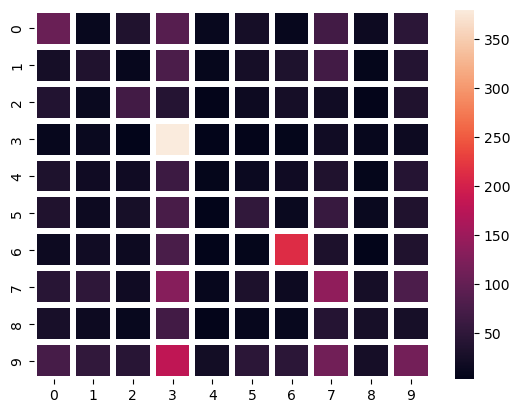

In [11]:
conf = confusion_matrix(y_val, knn_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Decision Tree

In [12]:
%%time

dt = DecisionTreeClassifier()

dt_params = {
    'max_depth': [10, 15, 30, 50]
    }
dt_model = GridSearchCV(dt, dt_params, cv=3, n_jobs=-1)
dt_model.fit(X_train, y_train)

print(f'Train accuracy for decision tree = {dt_model.score(X_train, y_train)}')
print(f'Validation accuracy for decision tree = {dt_model.score(X_val, y_val)}')
print(f'Test accuracy for decision tree = {dt_model.score(X_test, y_test)}')

Train accuracy for decision tree = 0.34429860098309295
Validation accuracy for decision tree = 0.3004789513486262
Test accuracy for decision tree = 0.3001512096774194
Wall time: 12.5 s


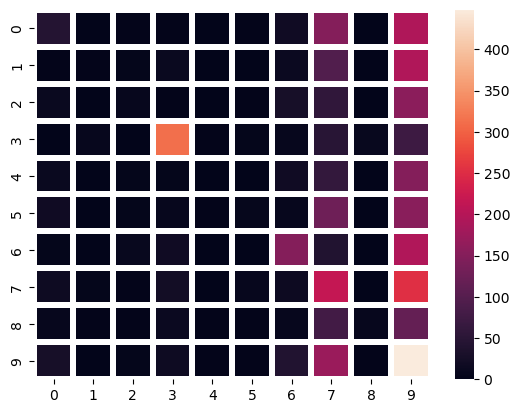

In [13]:
conf = confusion_matrix(y_val, dt_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Naive Bayes

In [14]:
%%time

nb = MultinomialNB()

nb_params = {
    'alpha': [0, 0.1, 0.2, 0.5, 1]
    }
nb_model = GridSearchCV(nb, nb_params, cv=3, n_jobs=-1)
nb_model.fit(X_train, y_train)

print(f'Train accuracy for naive bayes = {nb_model.score(X_train, y_train)}')
print(f'Validation accuracy for naive bayes = {nb_model.score(X_val, y_val)}')
print(f'Test accuracy for naive bayes = {nb_model.score(X_test, y_test)}')

Train accuracy for naive bayes = 0.40512072597634097
Validation accuracy for naive bayes = 0.38366523821527604
Test accuracy for naive bayes = 0.36567540322580644
Wall time: 279 ms


c:\Users\Ahmad Wali\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



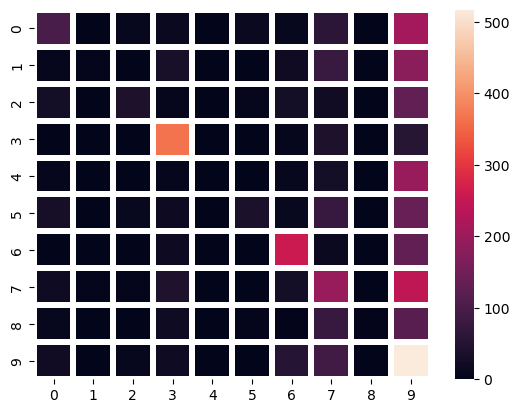

In [15]:
conf = confusion_matrix(y_val, nb_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### AdaBoost

In [16]:
%%time

ada = AdaBoostClassifier(base_estimator=RidgeClassifier(), algorithm='SAMME')

ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01, 1]
    }
ada_model = GridSearchCV(ada, ada_params, cv=3, n_jobs=-1)
ada_model.fit(X_train, y_train)

print(f'Train accuracy for Adaboost = {ada_model.score(X_train, y_train)}')
print(f'Validation accuracy for Adaboost = {ada_model.score(X_val, y_val)}')
print(f'Test accuracy for Adaboost = {ada_model.score(X_test, y_test)}')

Train accuracy for Adaboost = 0.39831469777993844
Validation accuracy for Adaboost = 0.3705570960423494
Test accuracy for Adaboost = 0.3626512096774194
Wall time: 2min 39s


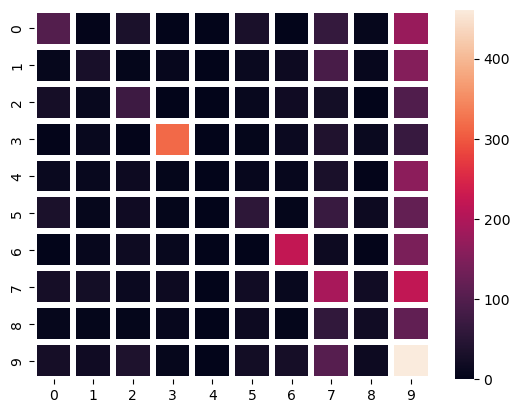

In [17]:
conf = confusion_matrix(y_val, ada_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### SVM

In [18]:
# %%time
# svm = SVC()

# svm_params = {
#     'C': [1, 5, 10],
#     'kernel': ['rbf', 'linear']
#     }
# svm_model = GridSearchCV(svm, svm_params, cv=3, n_jobs=-1)
# svm_model.fit(X_train, y_train)

# print(f'Train accuracy for svm = {svm_model.score(X_train, y_train)}')
# print(f'Validation accuracy for svm = {svm_model.score(X_val, y_val)}')
# print(f'Test accuracy for svm = {svm_model.score(X_test, y_test)}')

### Bag of Words

In [19]:
train_feats = trainset['Lyrics'].apply(preprocess).astype(str)
test_feats = testset['Lyrics'].apply(preprocess).astype(str)

In [20]:
bow = CountVectorizer(max_features=1000)
train_feats = bow.fit_transform(train_feats)
test_feats = bow.transform(test_feats)

# sm = RandomUnderSampler(random_state=42)
# X_train, y_train = sm.fit_resample(train_feats, trainset['labels']) 
X_train, y_train = train_feats, trainset['labels']
X_val, X_test, y_val, y_test = train_test_split(test_feats, testset['labels'], test_size=0.5)

#### KNN

In [21]:
%%time
knn_model.fit(X_train, y_train)

print(f'Train accuracy for KNN = {knn_model.score(X_train, y_train)}')
print(f'Validation accuracy for KNN = {knn_model.score(X_val, y_val)}')
print(f'Test accuracy for KNN = {knn_model.score(X_test, y_test)}')

Train accuracy for KNN = 0.39431750661697185
Validation accuracy for KNN = 0.27955633980337785
Test accuracy for KNN = 0.2716733870967742
Wall time: 1min


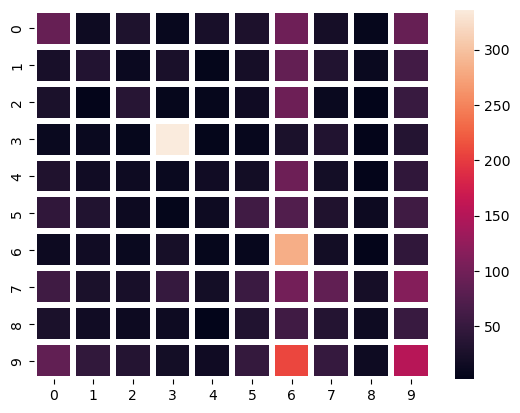

In [22]:
conf = confusion_matrix(y_val, knn_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Decision Tree

In [23]:
%%time
dt_model.fit(X_train, y_train)

print(f'Train accuracy for decision tree = {dt_model.score(X_train, y_train)}')
print(f'Validation accuracy for decision tree = {dt_model.score(X_val, y_val)}')
print(f'Test accuracy for decision tree = {dt_model.score(X_test, y_test)}')

Train accuracy for decision tree = 0.3535893696321504
Validation accuracy for decision tree = 0.30526846483488784
Test accuracy for decision tree = 0.3147681451612903
Wall time: 9.88 s


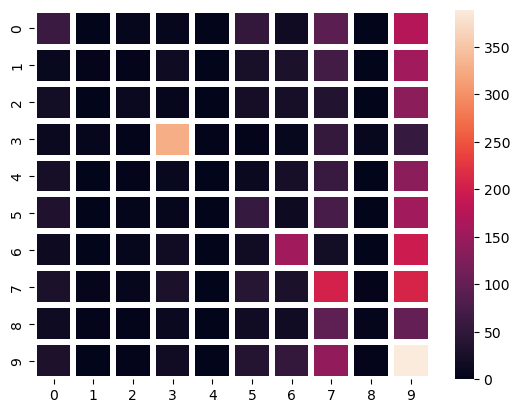

In [24]:
conf = confusion_matrix(y_val, dt_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Naive Bayes

In [25]:
%%time
nb_model.fit(X_train, y_train)

print(f'Train accuracy for naive bayes = {nb_model.score(X_train, y_train)}')
print(f'Validation accuracy for naive bayes = {nb_model.score(X_val, y_val)}')
print(f'Test accuracy for naive bayes = {nb_model.score(X_test, y_test)}')

Train accuracy for naive bayes = 0.408955868848917
Validation accuracy for naive bayes = 0.3544239979833627
Test accuracy for naive bayes = 0.3722278225806452
Wall time: 1.08 s


c:\Users\Ahmad Wali\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



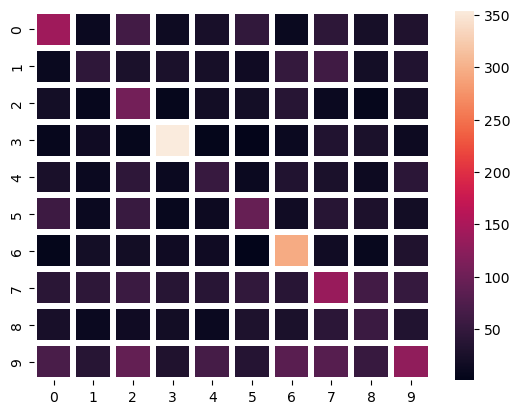

In [26]:
conf = confusion_matrix(y_val, nb_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Adaboost

In [27]:
%%time
ada_model.fit(X_train, y_train)

print(f'Train accuracy for Adaboost = {ada_model.score(X_train, y_train)}')
print(f'Validation accuracy for Adaboost = {ada_model.score(X_val, y_val)}')
print(f'Test accuracy for Adaboost = {ada_model.score(X_test, y_test)}')

Train accuracy for Adaboost = 0.4338572894722627
Validation accuracy for Adaboost = 0.37610284850012604
Test accuracy for Adaboost = 0.3868447580645161
Wall time: 5min 55s


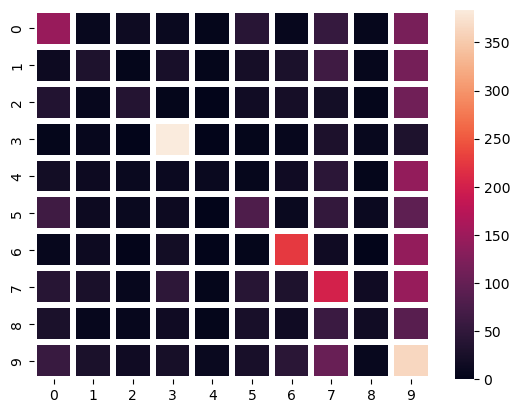

In [28]:
conf = confusion_matrix(y_val, ada_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Word2Vec

In [29]:
info = []

# iterate through each sentence in the file
for i in trainset['Lyrics']:
	vec = []
	
	# tokenize the sentence into words
	for j in word_tokenize(i):
		vec.append(j.lower())

	info.append(vec)

# Create Skip Gram model
w2v = gensim.models.Word2Vec(info, min_count = 1, vector_size = 1000,
											window = 5, sg = 1)


In [30]:
train_vectors = [];
for sent in trainset['Lyrics']: 
    vectors = np.zeros(1000)
    words =0;
    for word in sent:
        try:
            vec = w2v.wv[word]
            vectors += vec
            words += 1
        except:
            pass
    vectors /= words
    train_vectors.append(vectors)
train_vectors = np.array(train_vectors)
train_vectors = np.nan_to_num(train_vectors)
train_vectors.shape

(18513, 1000)

In [35]:
test_vectors = [];
for sent in testset['Lyrics']: 
    vectors = np.zeros(1000)
    words =0;
    for word in sent:
        try:
            vec = w2v.wv[word]
            vectors += vec
            words += 1
        except:
            pass
    vectors /= words
    test_vectors.append(vectors)
test_vectors = np.array(test_vectors)
test_vectors = np.nan_to_num(test_vectors)
test_vectors.shape

(7935, 1000)

In [37]:
X_train, y_train = train_vectors, trainset['labels']
X_val, X_test, y_val, y_test = train_test_split(test_vectors, testset['labels'], test_size=0.5)

#### KNN

In [38]:
%%time
knn_model.fit(X_train, y_train)

print(f'Train accuracy for KNN = {knn_model.score(X_train, y_train)}')
print(f'Validation accuracy for KNN = {knn_model.score(X_val, y_val)}')
print(f'Test accuracy for KNN = {knn_model.score(X_test, y_test)}')

Train accuracy for KNN = 0.37530384054448224
Validation accuracy for KNN = 0.2510713385429796
Test accuracy for KNN = 0.2542842741935484
Wall time: 25.3 s


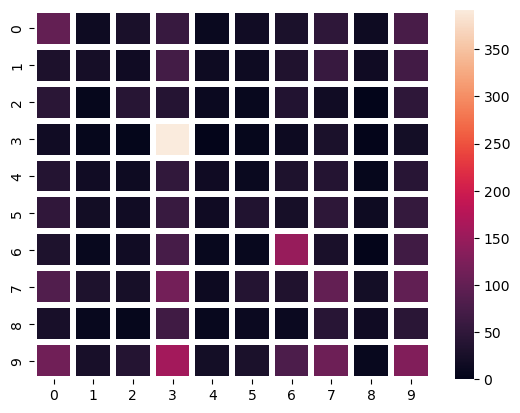

In [39]:
conf = confusion_matrix(y_val, knn_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Naive Bayes

In [40]:
%%time
nb_model.fit(MinMaxScaler().fit_transform(X_train), y_train)

print(f'Train accuracy for naive bayes = {nb_model.score(X_train, y_train)}')
print(f'Validation accuracy for naive bayes = {nb_model.score(X_val, y_val)}')
print(f'Test accuracy for naive bayes = {nb_model.score(X_test, y_test)}')

Train accuracy for naive bayes = 0.1776589423648247
Validation accuracy for naive bayes = 0.1784723972775397
Test accuracy for naive bayes = 0.1771673387096774
Wall time: 1.5 s


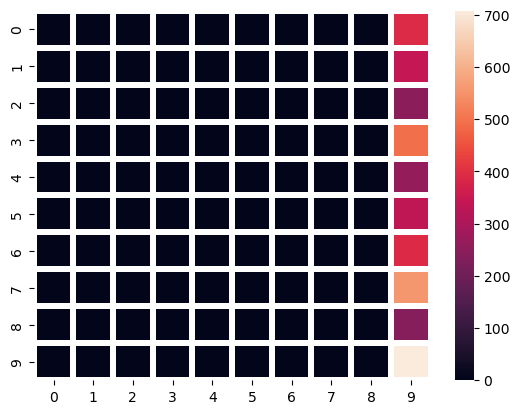

In [41]:
conf = confusion_matrix(y_val, nb_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### AdaBoost

In [42]:
%%time
ada_model.fit(X_train, y_train)

print(f'Train accuracy for Adaboost = {ada_model.score(X_train, y_train)}')
print(f'Validation accuracy for Adaboost = {ada_model.score(X_val, y_val)}')
print(f'Test accuracy for Adaboost = {ada_model.score(X_test, y_test)}')

Train accuracy for Adaboost = 0.2532274617836115
Validation accuracy for Adaboost = 0.25132341820015125
Test accuracy for Adaboost = 0.2542842741935484
Wall time: 9min


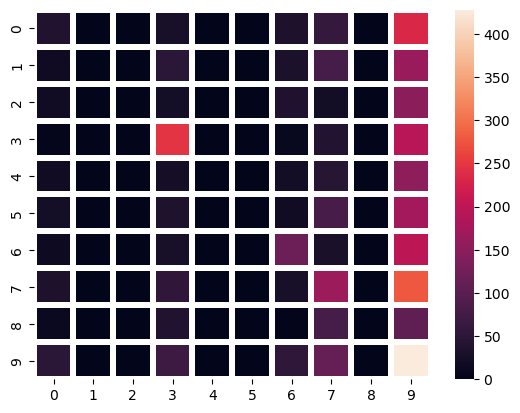

In [43]:
conf = confusion_matrix(y_val, ada_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Decision Tree

In [44]:
%%time
dt_model.fit(X_train, y_train)

print(f'Train accuracy for decision tree = {dt_model.score(X_train, y_train)}')
print(f'Validation accuracy for decision tree = {dt_model.score(X_val, y_val)}')
print(f'Test accuracy for decision tree = {dt_model.score(X_test, y_test)}')

Train accuracy for decision tree = 0.4420137200885864
Validation accuracy for decision tree = 0.23670279808419462
Test accuracy for decision tree = 0.24571572580645162
Wall time: 45.1 s


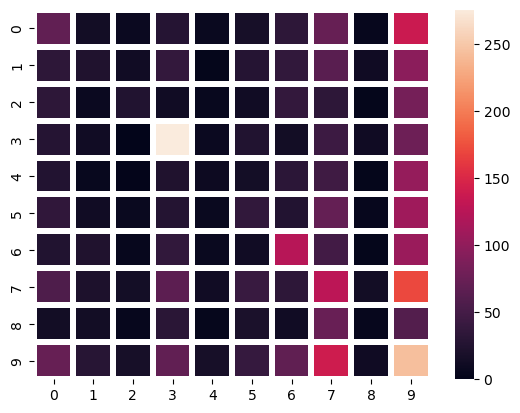

In [45]:
conf = confusion_matrix(y_val, dt_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

## Without Stopwords

In [46]:
train_feats = trainset['Lyrics'].apply(preprocess_2).astype(str)
test_feats = testset['Lyrics'].apply(preprocess_2).astype(str)

### TF-Idf

In [47]:
tfidf = TfidfVectorizer(max_features=1000)
train_feats = tfidf.fit_transform(train_feats)
test_feats = tfidf.transform(test_feats)

# sm = RandomUnderSampler(random_state=42)
# X_train, y_train = sm.fit_resample(train_feats, trainset['labels']) 
X_train, y_train = train_feats, trainset['labels']
X_val, X_test, y_val, y_test = train_test_split(test_feats, testset['labels'], test_size=0.5)

#### KNN

In [48]:
%%time

knn_model.fit(X_train, y_train)

print(f'Train accuracy for KNN = {knn_model.score(X_train, y_train)}')
print(f'Validation accuracy for KNN = {knn_model.score(X_val, y_val)}')
print(f'Test accuracy for KNN = {knn_model.score(X_test, y_test)}')

Train accuracy for KNN = 0.4043104845243883
Validation accuracy for KNN = 0.2659440383161079
Test accuracy for KNN = 0.26537298387096775
Wall time: 1min 25s


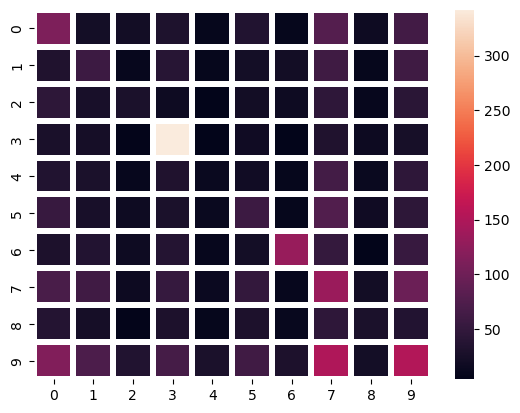

In [49]:
conf = confusion_matrix(y_val, knn_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Decision Tree

In [50]:
%%time
dt_model.fit(X_train, y_train)

print(f'Train accuracy for decision tree = {dt_model.score(X_train, y_train)}')
print(f'Validation accuracy for decision tree = {dt_model.score(X_val, y_val)}')
print(f'Test accuracy for decision tree = {dt_model.score(X_test, y_test)}')

Train accuracy for decision tree = 0.33344136552692705
Validation accuracy for decision tree = 0.2959415175195362
Test accuracy for decision tree = 0.28805443548387094
Wall time: 7.87 s


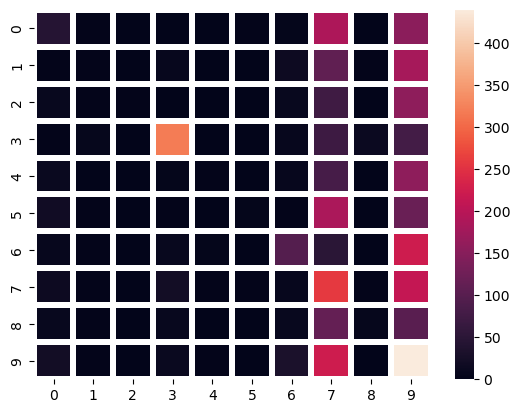

In [51]:
conf = confusion_matrix(y_val, dt_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### AdaBoost

In [52]:
%%time
ada_model.fit(X_train, y_train)

print(f'Train accuracy for Adaboost = {ada_model.score(X_train, y_train)}')
print(f'Validation accuracy for Adaboost = {ada_model.score(X_val, y_val)}')
print(f'Test accuracy for Adaboost = {ada_model.score(X_test, y_test)}')

Train accuracy for Adaboost = 0.39966510019985957
Validation accuracy for Adaboost = 0.3826569195865894
Test accuracy for Adaboost = 0.35912298387096775
Wall time: 1min 41s


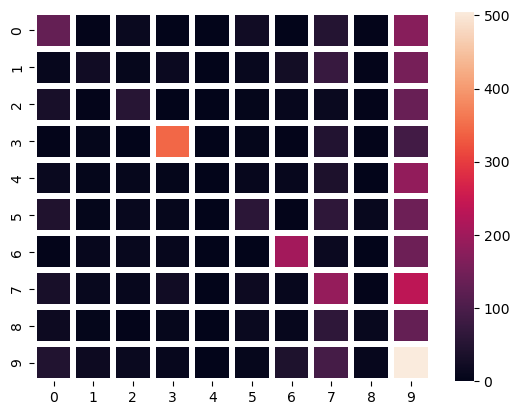

In [53]:
conf = confusion_matrix(y_val, ada_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Naive Bayes

In [54]:
%%time
nb_model.fit(X_train, y_train)

print(f'Train accuracy for naive bayes = {nb_model.score(X_train, y_train)}')
print(f'Validation accuracy for naive bayes = {nb_model.score(X_val, y_val)}')
print(f'Test accuracy for naive bayes = {nb_model.score(X_test, y_test)}')

Train accuracy for naive bayes = 0.4146815751093826
Validation accuracy for naive bayes = 0.3884547517015377
Test accuracy for naive bayes = 0.3676915322580645
Wall time: 250 ms


c:\Users\Ahmad Wali\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



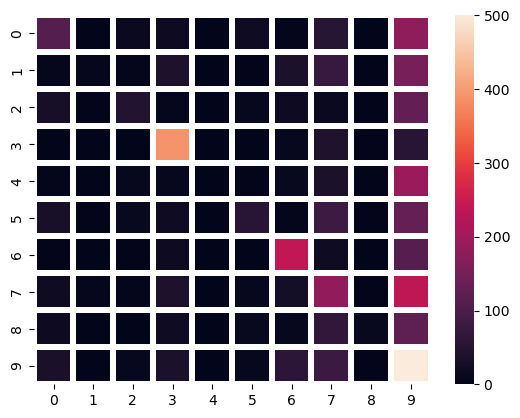

In [55]:
conf = confusion_matrix(y_val, nb_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

### Bag of Words

In [56]:
train_feats = trainset['Lyrics'].apply(preprocess_2).astype(str)
test_feats = testset['Lyrics'].apply(preprocess_2).astype(str)

In [57]:
bow = CountVectorizer(max_features=1000)
train_feats = bow.fit_transform(train_feats)
test_feats = bow.transform(test_feats)

# sm = RandomUnderSampler(random_state=42)
# X_train, y_train = sm.fit_resample(train_feats, trainset['labels']) 
X_train, y_train = train_feats, trainset['labels']
X_val, X_test, y_val, y_test = train_test_split(test_feats, testset['labels'], test_size=0.5)

#### KNN

In [58]:
%%time

knn_model.fit(X_train, y_train)

print(f'Train accuracy for KNN = {knn_model.score(X_train, y_train)}')
print(f'Validation accuracy for KNN = {knn_model.score(X_val, y_val)}')
print(f'Test accuracy for KNN = {knn_model.score(X_test, y_test)}')

Train accuracy for KNN = 0.36163776805488035
Validation accuracy for KNN = 0.23771111671288128
Test accuracy for KNN = 0.2366431451612903
Wall time: 53.9 s


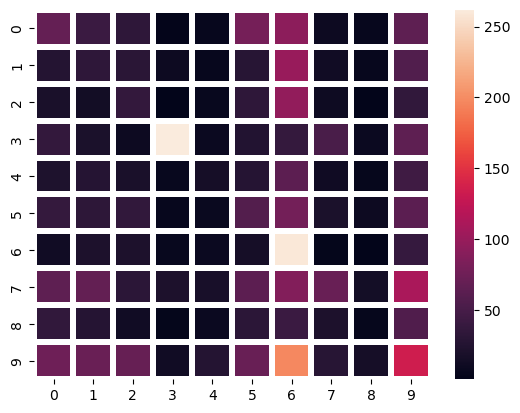

In [59]:
conf = confusion_matrix(y_val, knn_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Decision Tree

In [60]:
%%time
dt_model.fit(X_train, y_train)

print(f'Train accuracy for decision tree = {dt_model.score(X_train, y_train)}')
print(f'Validation accuracy for decision tree = {dt_model.score(X_val, y_val)}')
print(f'Test accuracy for decision tree = {dt_model.score(X_test, y_test)}')

Train accuracy for decision tree = 0.41343920488305513
Validation accuracy for decision tree = 0.3156037307789261
Test accuracy for decision tree = 0.28981854838709675
Wall time: 8.23 s


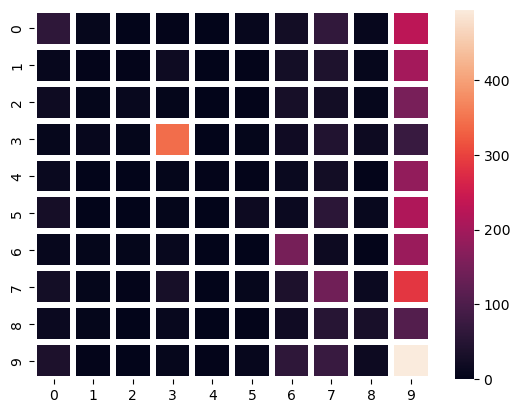

In [61]:
conf = confusion_matrix(y_val, dt_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Naive Bayes

In [62]:
%%time
nb_model.fit(X_train, y_train)

print(f'Train accuracy for naive bayes = {nb_model.score(X_train, y_train)}')
print(f'Validation accuracy for naive bayes = {nb_model.score(X_val, y_val)}')
print(f'Test accuracy for naive bayes = {nb_model.score(X_test, y_test)}')

Train accuracy for naive bayes = 0.42040728136984823
Validation accuracy for naive bayes = 0.3660196622132594
Test accuracy for naive bayes = 0.36517137096774194
Wall time: 254 ms


c:\Users\Ahmad Wali\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



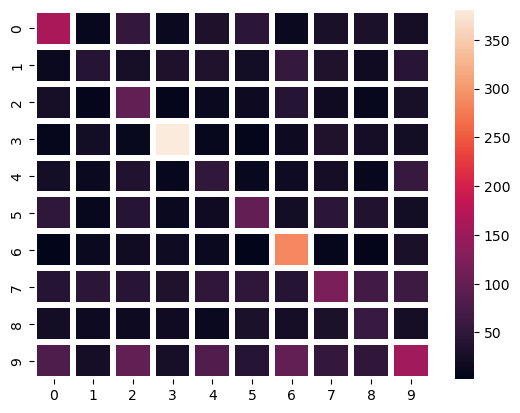

In [63]:
conf = confusion_matrix(y_val, nb_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### AdaBoost

In [64]:
%%time
ada_model.fit(X_train, y_train)

print(f'Train accuracy for AdaBoost = {ada_model.score(X_train, y_train)}')
print(f'Validation accuracy for AdaBoost = {ada_model.score(X_val, y_val)}')
print(f'Test accuracy for AdaBoost = {ada_model.score(X_test, y_test)}')

Train accuracy for AdaBoost = 0.42683519688867283
Validation accuracy for AdaBoost = 0.3763549281572977
Test accuracy for AdaBoost = 0.37298387096774194
Wall time: 2min 53s


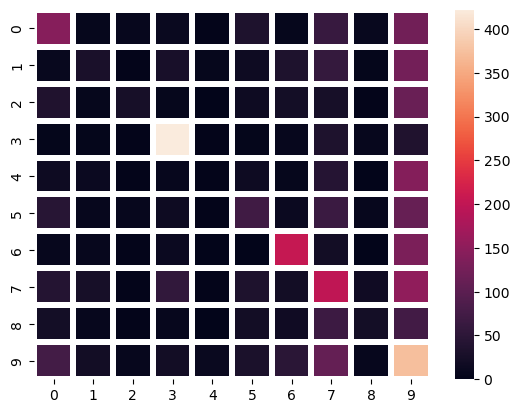

In [65]:
conf = confusion_matrix(y_val, ada_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

### Word2Vec

In [66]:
info = []

# iterate through each sentence in the file
for i in trainset['Lyrics']:
	vec = []
	
	# tokenize the sentence into words
	for j in word_tokenize(i):
		vec.append(j.lower())

	info.append(vec)

# Create Skip Gram model
w2v = gensim.models.Word2Vec(info, min_count = 1, vector_size = 1000,
											window = 5, sg = 1)


In [67]:
train_vectors = [];
for sent in trainset['Lyrics']: 
    vectors = np.zeros(1000)
    words =0;
    for word in sent:
        try:
            vec = w2v.wv[word]
            vectors += vec
            words += 1
        except:
            pass
    vectors /= words
    train_vectors.append(vectors)
train_vectors = np.array(train_vectors)
train_vectors = np.nan_to_num(train_vectors)
train_vectors.shape

(18513, 1000)

In [68]:
test_vectors = [];
for sent in testset['Lyrics']: 
    vectors = np.zeros(1000)
    words =0;
    for word in sent:
        try:
            vec = w2v.wv[word]
            vectors += vec
            words += 1
        except:
            pass
    vectors /= words
    test_vectors.append(vectors)
test_vectors = np.array(test_vectors)
test_vectors = np.nan_to_num(test_vectors)
test_vectors.shape

(7935, 1000)

In [69]:
X_train, y_train = train_vectors, trainset['labels']
X_val, X_test, y_val, y_test = train_test_split(test_vectors, testset['labels'], test_size=0.5)

#### KNN

In [70]:
%%time
knn_model.fit(X_train, y_train)

print(f'Train accuracy for KNN = {knn_model.score(X_train, y_train)}')
print(f'Validation accuracy for KNN = {knn_model.score(X_val, y_val)}')
print(f'Test accuracy for KNN = {knn_model.score(X_test, y_test)}')

Train accuracy for KNN = 0.37292713228542107
Validation accuracy for KNN = 0.24577766574237458
Test accuracy for KNN = 0.2600806451612903
Wall time: 20.3 s


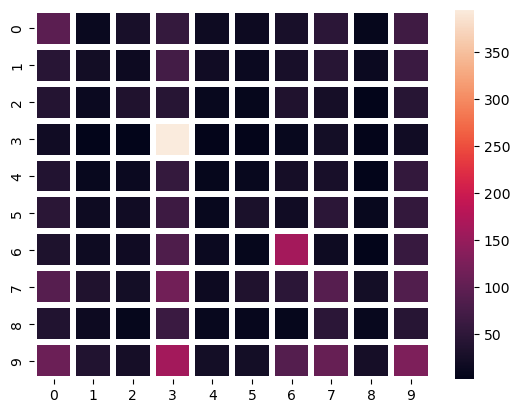

In [71]:
conf = confusion_matrix(y_val, knn_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Naive Bayes

In [72]:
%%time
nb_model.fit(MinMaxScaler().fit_transform(X_train), y_train)

print(f'Train accuracy for naive bayes = {nb_model.score(X_train, y_train)}')
print(f'Validation accuracy for naive bayes = {nb_model.score(X_val, y_val)}')
print(f'Test accuracy for naive bayes = {nb_model.score(X_test, y_test)}')

Train accuracy for naive bayes = 0.17782099065521526
Validation accuracy for naive bayes = 0.1822535921351147
Test accuracy for naive bayes = 0.17338709677419356
Wall time: 1.48 s


c:\Users\Ahmad Wali\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



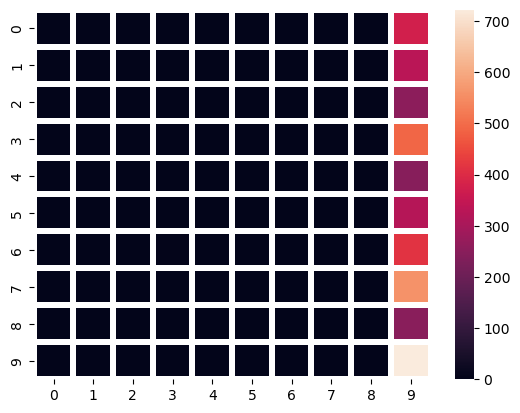

In [73]:
conf = confusion_matrix(y_val, nb_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### Decision Tree

In [74]:
%%time
dt_model.fit(X_train, y_train)

print(f'Train accuracy for decision tree = {dt_model.score(X_train, y_train)}')
print(f'Validation accuracy for decision tree = {dt_model.score(X_val, y_val)}')
print(f'Test accuracy for decision tree = {dt_model.score(X_test, y_test)}')

Train accuracy for decision tree = 0.42634905201750123
Validation accuracy for decision tree = 0.2397277539702546
Test accuracy for decision tree = 0.24848790322580644
Wall time: 46.4 s


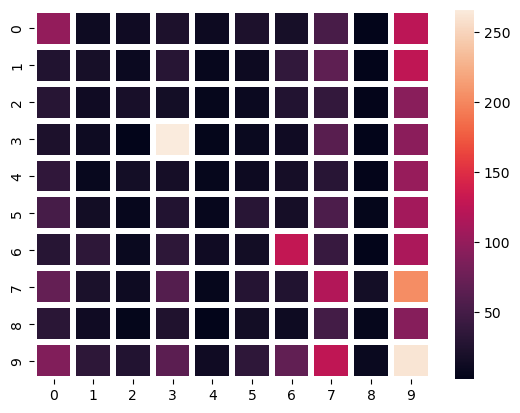

In [75]:
conf = confusion_matrix(y_val, dt_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

#### AdaBoost

In [76]:
%%time
ada_model.fit(X_train, y_train)

print(f'Train accuracy for Adaboost = {ada_model.score(X_train, y_train)}')
print(f'Validation accuracy for Adaboost = {ada_model.score(X_val, y_val)}')
print(f'Test accuracy for Adaboost = {ada_model.score(X_test, y_test)}')

Train accuracy for Adaboost = 0.24604332090963107
Validation accuracy for Adaboost = 0.2540962944290396
Test accuracy for Adaboost = 0.23865927419354838
Wall time: 9min 17s


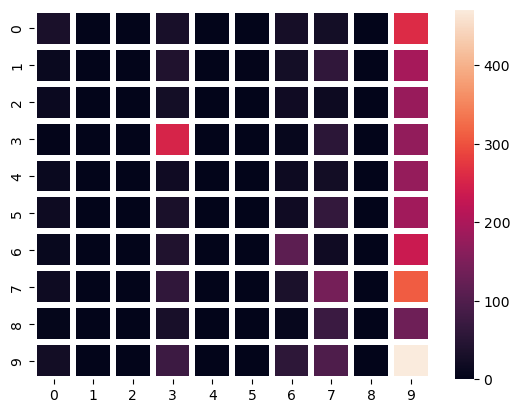

In [77]:
conf = confusion_matrix(y_val, ada_model.predict(X_val))
sns.heatmap(conf, linewidths = 4);

In [78]:
end = time.time()

In [82]:
print(f'Notebook ran in {str(datetime.timedelta(seconds=end-begin))}')

Notebook ran in 0:53:17.331752


In [117]:
ada_model.best_params_

{'learning_rate': 0.1, 'n_estimators': 150}

In [119]:
knn_model.best_params_

{'n_neighbors': 11}

In [120]:
dt_model.best_params_

{'max_depth': 10}

In [121]:
nb_model.best_params_

{'alpha': 0}